# Customer Segmentation Using Unsupervised Learning

### End-to-End ML Pipeline with Bias & Fairness Analysis

**Capstone Project | Asian Institute of Management | Post Graduate Diploma in AI and ML**  
Franz Fangonilo

=============================================================================

## Business Problem

Customers are often treated as a homogeneous group despite clear differences in:

- Purchasing behavior
- Spending intensity
- Engagement depth
- Promotion sensitivity

This leads to:
- Inefficient marketing spend
- Generic campaigns
- Missed personalization opportunities

**Goal:** Identify meaningful and actionable customer segments.

=============================================================================

## Data Science Problem Framing

- No labeled target variable
- Objective is to uncover *natural structure* in customer behavior
- Focus on similarity and separation, not prediction

**Task Type:** Unsupervised Learning (Clustering)

**Why clustering?**
- Structure discovery
- Interpretability
- Business actionability

=============================================================================

### Codes (Hidden Cell)

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

DATA_PATH = "C:\\Users\\ffangonilo\\OneDrive - CENTURY PACIFIC FOOD INC\\Documents\\AIM\\superstore_final_dataset.csv"
df_raw = pd.read_csv(
    DATA_PATH,
    encoding="latin1",
    low_memory=False
)
# -----------------------------
# 1. Basic Cleaning: nulls, duplicates, types
# -----------------------------
df = df_raw.copy()

# 1.1 Standardize column names (optional but helpful)
df.columns = [c.strip().replace(" ", "_") for c in df.columns]

# 1.2 Duplicate rows
dup_count = df.duplicated().sum()
if dup_count > 0:
    df = df.drop_duplicates()

# 1.3 Missing values
missing = df.isnull().mean().sort_values(ascending=False) * 100

# Simple missing handling:
# - For categorical: fill with "Unknown"
# - For numeric: fill with median
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

for c in cat_cols:
    df[c] = df[c].fillna("Unknown")

for c in num_cols:
    df[c] = df[c].fillna(df[c].median())

# 1.4 Parse dates if present
date_candidates = [c for c in df.columns if "date" in c.lower()]
for c in date_candidates:
    try:
        df[c] = pd.to_datetime(df[c])
    except Exception:
        pass

# -----------------------------
# 2. Domain Feature Engineering (Customer-level)
# -----------------------------
# Goal: clustering customers, so we aggregate transactions -> customer features.
# We'll try common Superstore-style columns, but keep it robust.

def find_col(possible_names):
    existing = set(df.columns)
    for name in possible_names:
        if name in existing:
            return name
    return None

COL_CUSTOMER_ID = find_col(["Customer_ID", "CustomerID", "Customer_Id"])
COL_CUSTOMER_NAME = find_col(["Customer_Name", "CustomerName"])
COL_ORDER_ID = find_col(["Order_ID", "OrderID"])
COL_ORDER_DATE = find_col(["Order_Date", "OrderDate"])
COL_SALES = find_col(["Sales", "sales"])
COL_PROFIT = find_col(["Profit", "profit"])
COL_DISCOUNT = find_col(["Discount", "discount"])
COL_QUANTITY = find_col(["Quantity", "quantity"])
COL_CATEGORY = find_col(["Category", "category"])
COL_SUBCATEGORY = find_col(["Sub_Category", "Sub-Category", "SubCategory", "sub_category"])
COL_REGION = find_col(["Region", "region"])
COL_SEGMENT = find_col(["Segment", "segment"])

# Base table for aggregation
work = df.copy()

# If no order date, create a dummy date index for recency-like fields
if COL_ORDER_DATE is None or not np.issubdtype(work[COL_ORDER_DATE].dtype, np.datetime64):
    use_recency = False
else:
    use_recency = True
    max_date = work[COL_ORDER_DATE].max()

# --- Customer aggregates
agg_dict = {}

# Behavioral/value
if COL_SALES:    agg_dict[COL_SALES] = ["sum", "mean", "median", "std"]
if COL_PROFIT:   agg_dict[COL_PROFIT] = ["sum", "mean", "median", "std"]
if COL_DISCOUNT: agg_dict[COL_DISCOUNT] = ["mean", "max", "std"]
if COL_QUANTITY: agg_dict[COL_QUANTITY] = ["sum", "mean", "max"]

# Order frequency proxies
if COL_ORDER_ID:
    order_counts = work.groupby(COL_CUSTOMER_ID)[COL_ORDER_ID].nunique().rename("n_orders")
else:
    # fallback: number of rows per customer
    order_counts = work.groupby(COL_CUSTOMER_ID).size().rename("n_orders")

cust = work.groupby(COL_CUSTOMER_ID).agg(agg_dict)
cust.columns = ["__".join(map(str, c)).strip() for c in cust.columns.to_flat_index()]
cust = cust.reset_index()

cust = cust.merge(order_counts.reset_index(), on=COL_CUSTOMER_ID, how="left")

# Recency: days since last purchase
if use_recency:
    last_order = work.groupby(COL_CUSTOMER_ID)[COL_ORDER_DATE].max()
    recency_days = (max_date - last_order).dt.days.rename("recency_days")
    cust = cust.merge(recency_days.reset_index(), on=COL_CUSTOMER_ID, how="left")

# Category diversity: how broad is the basket?
if COL_CATEGORY:
    cat_div = work.groupby(COL_CUSTOMER_ID)[COL_CATEGORY].nunique().rename("category_diversity")
    cust = cust.merge(cat_div.reset_index(), on=COL_CUSTOMER_ID, how="left")

if COL_SUBCATEGORY:
    subcat_div = work.groupby(COL_CUSTOMER_ID)[COL_SUBCATEGORY].nunique().rename("subcat_diversity")
    cust = cust.merge(subcat_div.reset_index(), on=COL_CUSTOMER_ID, how="left")

# Promo intensity / discount dependency (simple but useful)
if COL_DISCOUNT and COL_SALES:
    # share of sales with discount > 0
    disc_sales = work.assign(_disc_flag=(work[COL_DISCOUNT] > 0).astype(int))
    disc_share = (
        disc_sales.groupby(COL_CUSTOMER_ID)
        .apply(lambda g: np.average(g["_disc_flag"], weights=g[COL_SALES]) if g[COL_SALES].sum() > 0 else g["_disc_flag"].mean())
        .rename("discount_sales_weighted_share")
    )
    cust = cust.merge(disc_share.reset_index(), on=COL_CUSTOMER_ID, how="left")

# Add stable customer metadata if present (mode)
def mode_safe(s):
    m = s.mode()
    return m.iloc[0] if len(m) else "Unknown"

meta_cols = [c for c in [COL_SEGMENT, COL_REGION] if c is not None]
for mc in meta_cols:
    meta = work.groupby(COL_CUSTOMER_ID)[mc].apply(mode_safe).rename(mc)
    cust = cust.merge(meta.reset_index(), on=COL_CUSTOMER_ID, how="left")

# -----------------------------
# 3. Applied EDA (Customer-level)
#    - distributions
#    - correlations
#    - clustering tendency (Hopkins)
# -----------------------------
# 3.1 Identify numeric/categorical cols in customer table
cust_num = cust.select_dtypes(include=["int64", "float64"]).columns.tolist()
cust_cat = cust.select_dtypes(include=["object"]).columns.tolist()
# Drop ID from numeric if it got inferred (rare), and keep ID separately
if COL_CUSTOMER_ID in cust_num:
    cust_num.remove(COL_CUSTOMER_ID)

# 3.4 Clustering tendency: Hopkins statistic (0.5 ~ random, closer to 1 indicates clusters)
def hopkins_statistic(X, m=200, random_state=42):
    rng = np.random.default_rng(random_state)
    n = X.shape[0]
    m = min(m, n)

    # sample m points from X
    idx = rng.choice(n, size=m, replace=False)
    X_m = X[idx]

    # generate m random points within min-max of each feature
    mins = X.min(axis=0)
    maxs = X.max(axis=0)
    U = rng.uniform(mins, maxs, size=(m, X.shape[1]))

    # distances to nearest neighbor (excluding self)
    dist_X = pairwise_distances(X_m, X)
    # set self-distance to inf by matching indices
    for i, original_idx in enumerate(idx):
        dist_X[i, original_idx] = np.inf
    w = np.min(dist_X, axis=1)

    dist_U = pairwise_distances(U, X)
    u = np.min(dist_U, axis=1)

    H = u.sum() / (u.sum() + w.sum())
    return float(H)

# For Hopkins we need a numeric matrix; we'll build a simple scaled numeric-only view
X_for_hopkins = cust[cust_num].copy()
X_for_hopkins = X_for_hopkins.replace([np.inf, -np.inf], np.nan).fillna(0)
X_for_hopkins = StandardScaler().fit_transform(X_for_hopkins)
H = hopkins_statistic(X_for_hopkins, m=200, random_state=42)

# -----------------------------
# 4. Outlier Handling (Customer-level)
#    - winsorize numeric features using IQR caps
# -----------------------------
cust_fe = cust.copy()

def iqr_cap_series(s, factor=1.5):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lo = q1 - factor * iqr
    hi = q3 + factor * iqr
    return s.clip(lower=lo, upper=hi), lo, hi

outlier_caps = []
for col in cust_num:
    capped, lo, hi = iqr_cap_series(cust_fe[col], factor=1.5)
    n_capped = (capped != cust_fe[col]).sum()
    outlier_caps.append({"feature": col, "n_capped": int(n_capped), "cap_low": float(lo), "cap_high": float(hi)})
    cust_fe[col] = capped

outlier_caps = pd.DataFrame(outlier_caps).sort_values("n_capped", ascending=False)

# -----------------------------
# 5. Feature Engineering (Scaling, Encoding, Binning)
# -----------------------------
# Example binning (domain-ish): recency buckets if recency exists
if "recency_days" in cust_fe.columns:
    cust_fe["recency_bucket"] = pd.cut(
        cust_fe["recency_days"],
        bins=[-np.inf, 30, 90, 180, 365, np.inf],
        labels=["<=30d", "31-90d", "91-180d", "181-365d", ">365d"]
    ).astype(str)

# Another binning example: discount dependency bucket
if "discount_sales_weighted_share" in cust_fe.columns:
    cust_fe["discount_dependency_bucket"] = pd.cut(
        cust_fe["discount_sales_weighted_share"],
        bins=[-np.inf, 0.0, 0.2, 0.5, 0.8, np.inf],
        labels=["none", "low", "medium", "high", "extreme"]
    ).astype(str)

# Update categorical list after bins
cust_cat = cust_fe.select_dtypes(include=["object"]).columns.tolist()

# Keep ID aside
id_series = cust_fe[COL_CUSTOMER_ID].copy()
X = cust_fe.drop(columns=[COL_CUSTOMER_ID], errors="ignore")

# Define numeric & categorical columns for modeling
model_num = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
model_cat = X.select_dtypes(include=["object"]).columns.tolist()

# -----------------------------
# 6. Feature Selection (Filter method)
#    - remove near-zero variance features
#    - remove one of highly correlated pairs (after preprocessing)
# -----------------------------
# Preprocess: scale numeric + one-hot encode categorical
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, model_num),
        ("cat", categorical_transformer, model_cat)
    ],
    remainder="drop"
)

X_pre = preprocess.fit_transform(X)

# Get feature names after preprocessing
# (works for sklearn >= 1.0)
num_names = model_num
cat_ohe = preprocess.named_transformers_["cat"].named_steps["onehot"]
cat_names = cat_ohe.get_feature_names_out(model_cat).tolist()
feature_names = num_names + cat_names

X_pre_df = pd.DataFrame(X_pre, columns=feature_names)

# 6.1 Variance threshold
vt = VarianceThreshold(threshold=1e-6)
X_vt = vt.fit_transform(X_pre_df)
kept_mask = vt.get_support()
kept_features = X_pre_df.columns[kept_mask].tolist()

X_vt_df = pd.DataFrame(X_vt, columns=kept_features)

# 6.2 Correlation filter (remove one of each highly correlated pair)
# NOTE: With one-hot features, correlations can happen; we’ll filter carefully.
def correlation_filter(df_in, threshold=0.95):
    corr = df_in.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [c for c in upper.columns if any(upper[c] > threshold)]
    df_out = df_in.drop(columns=to_drop)
    return df_out, to_drop

X_fs_df, dropped_corr = correlation_filter(X_vt_df, threshold=0.95)

# -----------------------------
# FINAL NaN SAFETY CHECK (before PCA)
# -----------------------------
# Median imputation (robust, clustering-safe)
X_fs_df = X_fs_df.fillna(X_fs_df.median())

# -----------------------------
# 7. Dimensionality Reduction
#    - PCA for modeling + explained variance
#    - t-SNE for visualization (optional)
# -----------------------------
# 7.1 PCA
pca = PCA(n_components=0.90, random_state=42)  # keep enough PCs to explain 90% variance
X_pca = pca.fit_transform(X_fs_df)

explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

# 7.2 t-SNE visualization (on PCA-reduced data for speed)
# Tip: t-SNE is for visualization; not used as a modeling transform.
tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=42)
X_tsne = tsne.fit_transform(X_pca)

# -----------------------------
# 8. "Feature Importance / Explainability" for Unsupervised
#    Approach: build clusters -> train a surrogate classifier -> importances/SHAP
# -----------------------------
# 8.1 Create provisional clusters (KMeans on PCA space)
# (Final model choice belongs to Step 4, but this enables explainability here.)
k = 2
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
cluster_labels = kmeans.fit_predict(X_pca)

# 8.2 Surrogate model: predict cluster labels from engineered features
rf = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
rf.fit(X_fs_df, cluster_labels)

# Permutation importance for global interpretability
perm = permutation_importance(
    rf, X_fs_df, cluster_labels,
    n_repeats=10, random_state=42, n_jobs=-1
)

imp = pd.DataFrame({
    "feature": X_fs_df.columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

# ============================================================
# Models: KMeans, Agglomerative, DBSCAN
# Metrics: Silhouette, Davies-Bouldin, Calinski-Harabasz
# Reproducibility: save configs + artifacts
# ============================================================

import json
import joblib

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.utils import resample
RANDOM_STATE = 42

# -----------------------------
# 0. Load PCA features
# -----------------------------
X_pca = pd.read_csv("X_pca.csv")
X = X_pca.values

# Output folders (simple)
ARTIFACT_DIR = "step4_artifacts"
import os
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# -----------------------------
# Helper: evaluate clustering
# -----------------------------
def evaluate_clustering(X, labels):
    """Compute internal metrics. Returns dict. Handles edge cases."""
    # Need at least 2 clusters and no all-noise for silhouette etc.
    unique = set(labels)
    # For DBSCAN, -1 is noise; exclude only-noise case
    n_clusters = len([u for u in unique if u != -1])

    out = {
        "n_clusters": n_clusters,
        "noise_pct": float(np.mean(labels == -1) * 100.0) if -1 in unique else 0.0,
        "silhouette": None,
        "davies_bouldin": None,
        "calinski_harabasz": None
    }

    # Metrics only valid when there are >=2 clusters and not all same label
    if n_clusters >= 2:
        # For DBSCAN, silhouette should ignore noise points
        if -1 in unique:
            mask = labels != -1
            if mask.sum() >= 2 and len(set(labels[mask])) >= 2:
                out["silhouette"] = float(silhouette_score(X[mask], labels[mask]))
                out["davies_bouldin"] = float(davies_bouldin_score(X[mask], labels[mask]))
                out["calinski_harabasz"] = float(calinski_harabasz_score(X[mask], labels[mask]))
        else:
            out["silhouette"] = float(silhouette_score(X, labels))
            out["davies_bouldin"] = float(davies_bouldin_score(X, labels))
            out["calinski_harabasz"] = float(calinski_harabasz_score(X, labels))

    return out

# -----------------------------
# Helper: stability via resampling (KMeans/Agglo only)
# -----------------------------
def stability_score_kmeans_like(X, model_builder, n_boot=10, sample_frac=0.8, random_state=42):
    """
    Proxy stability measure: compare cluster center assignments consistency
    across bootstrap samples by comparing silhouette variability.
    (Simple and report-friendly.)
    """
    rng = np.random.default_rng(random_state)
    sils = []

    for i in range(n_boot):
        idx = rng.choice(len(X), size=int(len(X) * sample_frac), replace=True)
        Xb = X[idx]
        model = model_builder()
        labels = model.fit_predict(Xb)
        ev = evaluate_clustering(Xb, labels)
        sils.append(ev["silhouette"] if ev["silhouette"] is not None else np.nan)

    sils = np.array(sils, dtype=float)
    return {
        "silhouette_mean": float(np.nanmean(sils)),
        "silhouette_std": float(np.nanstd(sils))
    }


# ============================================================
# 1) KMEANS: Tune K using elbow + silhouette
# ============================================================
k_range = range(2, 11)
kmeans_rows = []
inertias = []
silhouettes = []

for k in k_range:
    model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
    labels = model.fit_predict(X)
    inertias.append(model.inertia_)
    ev = evaluate_clustering(X, labels)
    ev.update({"model": "kmeans", "k": k})
    kmeans_rows.append(ev)
    silhouettes.append(ev["silhouette"])

kmeans_results = pd.DataFrame(kmeans_rows)


# Choose best K by silhouette (you can override for business interpretability)
best_k = int(kmeans_results.sort_values("silhouette", ascending=False).iloc[0]["k"])
best_kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init="auto")
kmeans_labels = best_kmeans.fit_predict(X)
kmeans_eval = evaluate_clustering(X, kmeans_labels)
kmeans_stab = stability_score_kmeans_like(
    X,
    model_builder=lambda: KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init="auto"),
    n_boot=15
)


# ============================================================
# 2) AGGLOMERATIVE: Tune number of clusters
# ============================================================
agg_range = range(2, 11)
agg_rows = []

# Ward linkage works well with Euclidean space (PCA)
for k in agg_range:
    model = AgglomerativeClustering(n_clusters=k, linkage="ward")
    labels = model.fit_predict(X)
    ev = evaluate_clustering(X, labels)
    ev.update({"model": "agglomerative", "k": k, "linkage": "ward"})
    agg_rows.append(ev)

agg_results = pd.DataFrame(agg_rows)

best_k_agg = int(agg_results.sort_values("silhouette", ascending=False).iloc[0]["k"])
best_agg = AgglomerativeClustering(n_clusters=best_k_agg, linkage="ward")
agg_labels = best_agg.fit_predict(X)

agg_eval = evaluate_clustering(X, agg_labels)
# Stability proxy (re-fit on resamples)
agg_stab = stability_score_kmeans_like(
    X,
    model_builder=lambda: AgglomerativeClustering(n_clusters=best_k_agg, linkage="ward"),
    n_boot=15
)

# ============================================================
# 3) DBSCAN: Tune eps and min_samples
# ============================================================
eps_grid = [0.5, 0.8, 1.0, 1.2, 1.5]
min_samples_grid = [5, 10, 20]

db_rows = []

for eps in eps_grid:
    for ms in min_samples_grid:
        model = DBSCAN(eps=eps, min_samples=ms)
        labels = model.fit_predict(X)
        ev = evaluate_clustering(X, labels)
        ev.update({"model": "dbscan", "eps": eps, "min_samples": ms})
        db_rows.append(ev)

db_results = pd.DataFrame(db_rows)

# Choose a DBSCAN config that balances silhouette and coverage
# Here we choose highest silhouette among configs with <= 30% noise if possible.
candidates = db_results.copy()
candidates = candidates[candidates["noise_pct"] <= 30]
if len(candidates) == 0:
    candidates = db_results.copy()

best_db = candidates.sort_values(["silhouette", "noise_pct"], ascending=[False, True]).iloc[0]
best_eps = float(best_db["eps"])
best_ms = int(best_db["min_samples"])

best_dbscan = DBSCAN(eps=best_eps, min_samples=best_ms)
db_labels = best_dbscan.fit_predict(X)
db_eval = evaluate_clustering(X, db_labels)

# ============================================================
# 4) Consolidate comparison table
# ============================================================
summary_rows = []
summary_rows.append({"model": f"KMeans(k={best_k})", **kmeans_eval, **{f"stab_sil_mean": kmeans_stab["silhouette_mean"], "stab_sil_std": kmeans_stab["silhouette_std"]}})
summary_rows.append({"model": f"Agglomerative(k={best_k_agg})", **agg_eval, **{f"stab_sil_mean": agg_stab["silhouette_mean"], "stab_sil_std": agg_stab["silhouette_std"]}})
summary_rows.append({"model": f"DBSCAN(eps={best_eps},ms={best_ms})", **db_eval})
summary = pd.DataFrame(summary_rows)

# Load customer-level data
df = pd.read_csv("customer_features_with_provisional_clusters.csv")
# Rename cluster column if needed
df = df.rename(columns={"cluster_provisional_kmeans": "cluster"})

def cluster_distribution(df, group_col, cluster_col="cluster", normalize=True):
    """
    Returns cluster distribution per group.
    """
    dist = (
        df.groupby([cluster_col, group_col])
          .size()
          .unstack(fill_value=0)
    )

    if normalize:
        dist = dist.div(dist.sum(axis=1), axis=0)

    return dist

def disparate_impact(df, group_col, target_cluster, cluster_col="cluster"):
    """
    Computes Disparate Impact ratio for belonging to a given cluster.
    """
    rates = (
        df.assign(is_target=lambda x: (x[cluster_col] == target_cluster).astype(int))
          .groupby(group_col)["is_target"]
          .mean()
    )

    di_ratio = rates.min() / rates.max()
    return rates, di_ratio

behavioral_features = [
    "Sales__sum",
    "Sales__mean",
    "Sales__median",
    "Sales__std",
    "n_orders",
    "subcat_diversity"
]

behavioral_summary = (
    df.groupby("cluster")[behavioral_features]
      .agg(["mean", "median", "std"])
)

segment_dist = cluster_distribution(df, "Segment")
rates_seg, di_seg = disparate_impact(
    df,
    group_col="Segment",
    target_cluster=1   # change if cluster of interest differs
)
region_dist = cluster_distribution(df, "Region")
rates_reg, di_reg = disparate_impact(
    df,
    group_col="Region",
    target_cluster=1
)

=============================================================================
## Dataset Overview

**Source:** Kaggle – Superstore Sales Dataset  
**Unit of Analysis:** Customer (aggregated from transactions)

### Feature Types
- Behavioral & Value (sales, orders, diversity)
- Promotional sensitivity
- Stable attributes (segment, region)

In [17]:
display(df_raw.head(2))

,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,Country,City,State,Region,Product_ID,Category,Sub_Category,Product_Name,Sales
0,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96
1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94


=============================================================================

## Feature Engineering

Transactional data aggregated to customer-level:

### Behavioral & Value
- Total, mean, median, std of sales
- Number of orders
- Sub-category diversity

### Stable Attributes
- Modal customer segment
- Modal region

In [18]:
cust.head(2)

,Customer_ID,Sales__sum,Sales__mean,Sales__median,Sales__std,n_orders,category_diversity,subcat_diversity,Segment,Region
0,AA-10315,5563.56,505.778182,41.72,1157.990034,5,3,9,Consumer,Central
1,AA-10375,1056.39,70.426000,17.94,126.508857,9,3,7,Consumer,East


=============================================================================

## EDA & Clustering Suitability

- Strong right-skew in customer value
- High heterogeneity across customers
- Strong correlation among sales features

### Hopkins Statistic
H = 0.946

➡️ Strong evidence of non-random cluster structure

## Distributions

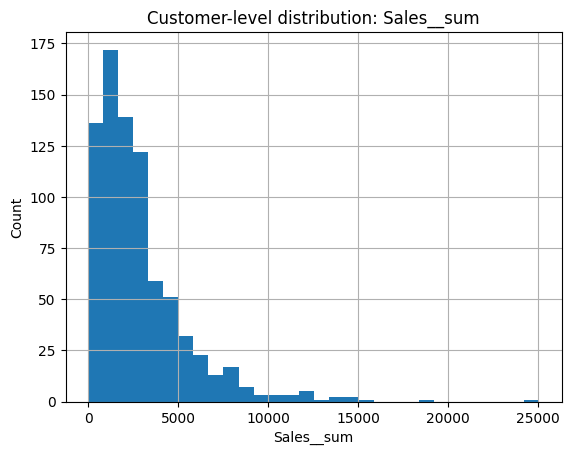

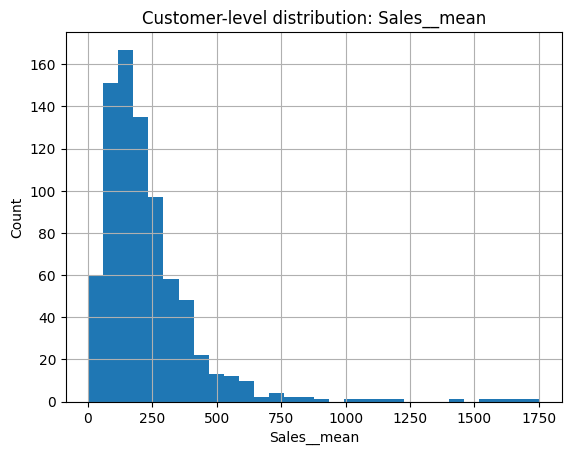

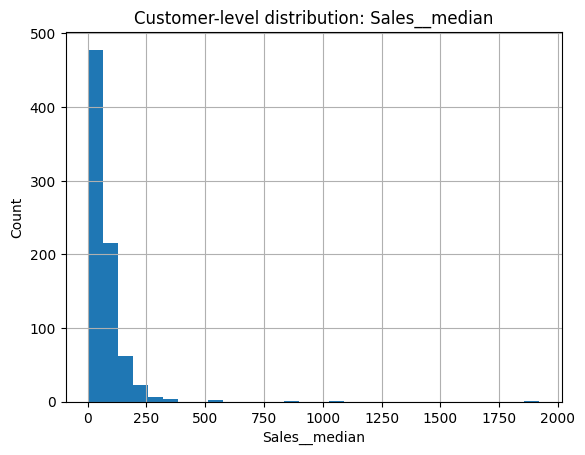

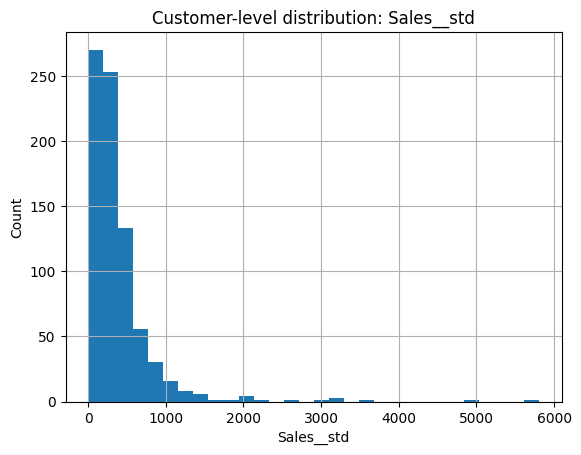

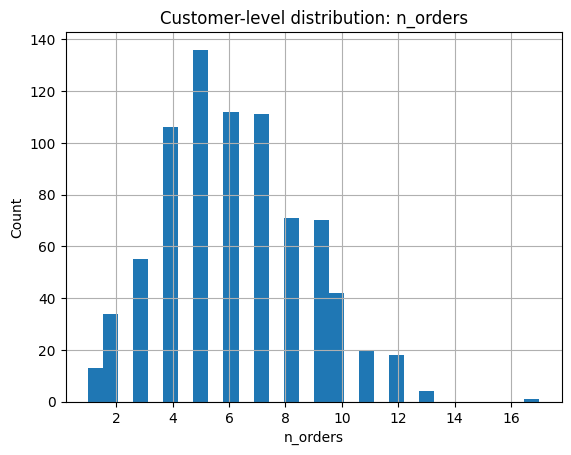

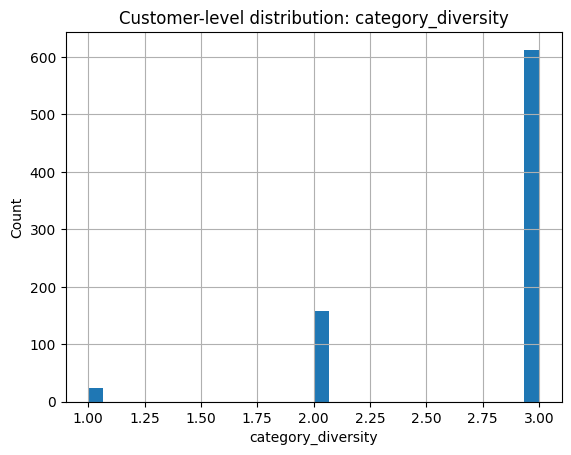

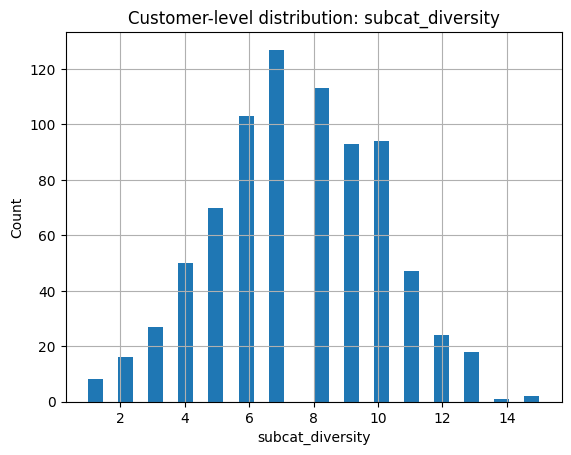

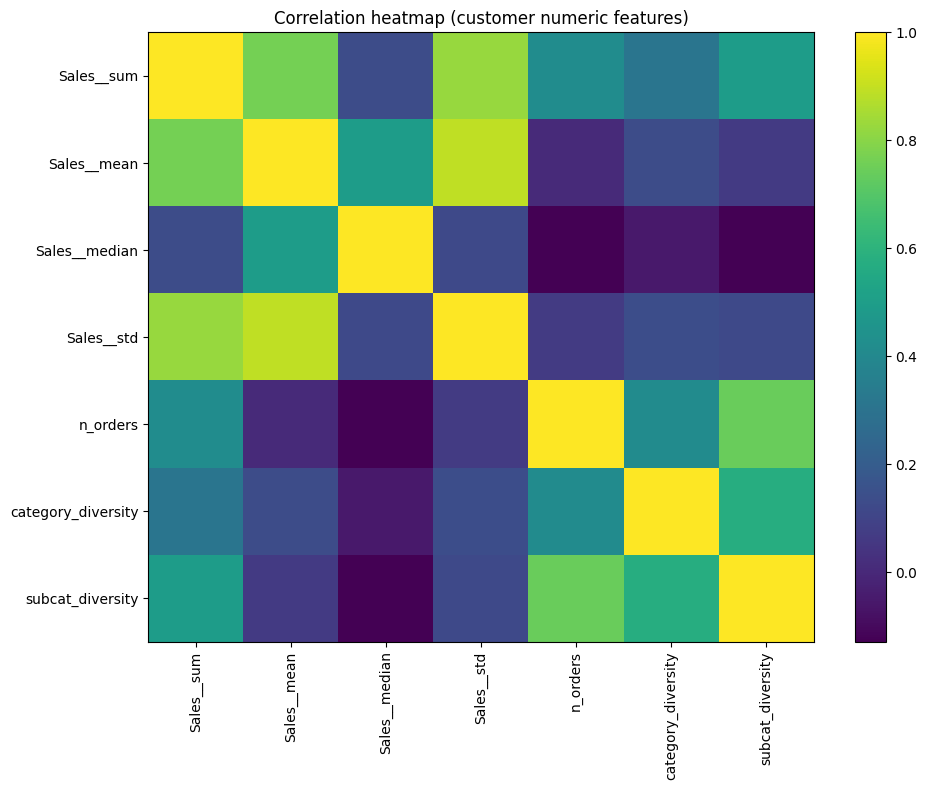

In [19]:
for col in cust_num:
    plt.figure()
    cust[col].hist(bins=30)
    plt.title(f"Customer-level distribution: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

if len(cust_num) >= 2:
    corr = cust[cust_num].corr()
    plt.figure(figsize=(10, 8))
    plt.imshow(corr, aspect="auto")
    plt.title("Correlation heatmap (customer numeric features)")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

=============================================================================

## Preprocessing Pipeline

- Median / mode imputation
- IQR-based winsorization (outlier capping)
- One-hot encoding
- Z-score scaling
- Variance & correlation filtering

=============================================================================

## Dimensionality Reduction

**PCA applied to selected features**

- Components retained: 7
- Explained variance: 93.05%

Benefits:
- Noise reduction
- Computational efficiency
- Improved clustering stability

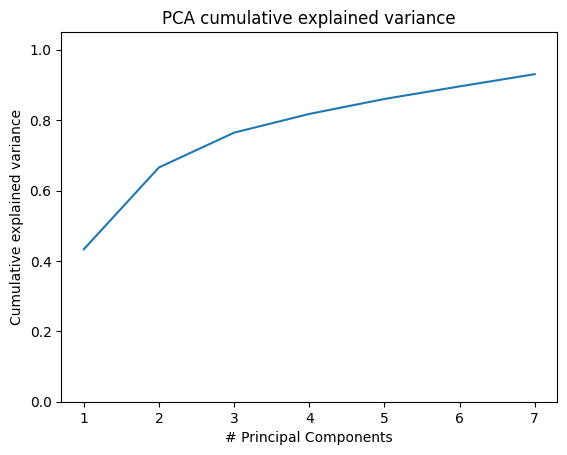


PCA components kept: 7
Cumulative explained variance: 0.9305085829226846


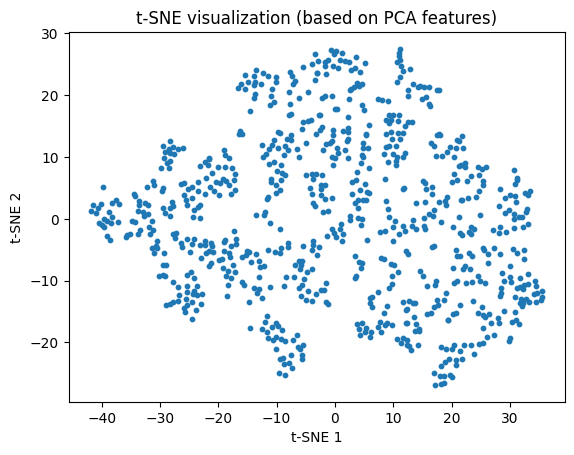

In [20]:
plt.figure()
plt.plot(range(1, len(cum_explained) + 1), cum_explained)
plt.title("PCA cumulative explained variance")
plt.xlabel("# Principal Components")
plt.ylabel("Cumulative explained variance")
plt.ylim(0, 1.05)
plt.show()

print("\nPCA components kept:", X_pca.shape[1])
print("Cumulative explained variance:", float(cum_explained[-1]))

plt.figure()
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=10)
plt.title("t-SNE visualization (based on PCA features)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

=============================================================================

## Clustering Models Evaluated

1. K-Means
2. Agglomerative (Hierarchical)
3. DBSCAN

Clustering performed on PCA-reduced feature space.

## Evaluation Metrics

Unsupervised internal validation:

- Silhouette Score (↑ better)
- Davies–Bouldin Index (↓ better)
- Calinski–Harabasz Index (↑ better)

Also evaluated:
- Stability via bootstrap resampling
- Cluster coverage

In [21]:
display(summary)

,model,n_clusters,noise_pct,silhouette,davies_bouldin,calinski_harabasz,stab_sil_mean,stab_sil_std
0,KMeans(k=2),2,0.000000,0.297897,1.375186,363.987352,0.304724,0.012183
1,Agglomerative(k=2),2,0.000000,0.198969,1.801444,223.760970,0.251714,0.051644
2,"DBSCAN(eps=1.5,ms=10)",2,10.340479,0.353702,0.798921,90.639954,NaN,NaN


=============================================================================

## Model Comparison (Best Configurations)

| Model | Silhouette | DB Index | CH Index | Stability |
|------|-----------|----------|----------|-----------|
| K-Means (k=2) | 0.298 | 1.375 | 363.99 | High |
| Agglomerative | 0.199 | 1.801 | 223.76 | Low |
| DBSCAN | 0.354 | 0.799 | 90.64 | N/A |

DBSCAN had strong separation but excluded ~10% as noise.

## Final Model Selection

**Selected Model:** K-Means (k = 2)

### Why?
- Full customer coverage
- High stability
- Strong global separation
- Easy business interpretation

Best trade-off between rigor and usability.

## Explainability Strategy

Clustering models lack native feature importance.

**Solution:**
- Train Random Forest surrogate to predict cluster labels
- Use permutation importance


=============================================================================

## Feature Importance (Surrogate Model)

Top Drivers:
- Total Sales
- Mean Sales
- Median Sales
- Sales Variability
- Number of Orders
- Sub-category Diversity

Demographic proxies (segment, region):
- Near-zero importance

➡️ Segmentation is behavior-driven

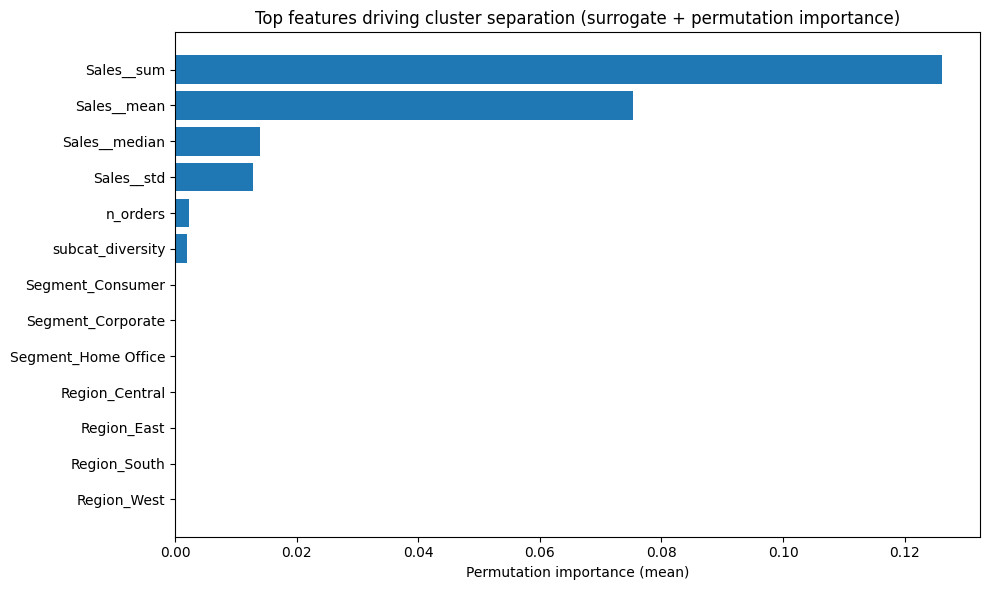

In [23]:
plt.figure(figsize=(10, 6))
topn = 15
plt.barh(imp.head(topn)["feature"][::-1], imp.head(topn)["importance_mean"][::-1])
plt.title("Top features driving cluster separation (surrogate + permutation importance)")
plt.xlabel("Permutation importance (mean)")
plt.tight_layout()
plt.show()

=============================================================================

## Bias & Fairness Analysis

Audited proxy-sensitive attributes:
- Customer Segment
- Region

Metrics:
- Cluster assignment probability
- Disparate impact ratios

**Fairness Interpretation**

- Disparate impact ≈ 0.74
- No sensitive attributes used in training
- Proxy features have negligible influence

Observed disparities reflect **behavioral differences**, not algorithmic bias.

Ethical risk exists at deployment, not modeling.


=============================================================================

## Cluster Profiling: Transactional & Behavioral

**Cluster 1 (High-Value)**
- ~3× higher total sales
- Higher order frequency
- Broader product diversity

**Cluster 0 (Lower-Value)**
- Lower spend
- Fewer orders
- Narrower engagement

**Segment & Region Composition**

- Similar distribution across Consumer, Corporate, Home Office
- Regions evenly represented

➡️ Demographics and geography do NOT drive clustering


**Cluster Personas**

**Cluster 0**
- Occasional / lower-intensity buyers
- Price-sensitive
- Activation & upsell opportunities

**Cluster 1**
- High-value, engaged customers
- Broad product exploration
- Ideal for loyalty & personalization


=============================================================================

## Business & Ethical Implications

- Enables behavior-based targeting
- Avoids demographic discrimination
- Requires governance in downstream use

Clusters should guide personalization—not exclusion.

## Key Takeaways

- Strong customer segmentation achieved
- Behavioral features dominate
- Fairness risks are manageable with governance
- Model is robust, interpretable, and deployable

=============================================================================